# 井点属性自动提取 + 伪样本生成


In [1]:
# 确保src目录在Python路径中
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

sys.path.append(os.path.abspath("../"))

# 导入模块
from src.data_utils import (
    extract_seismic_attributes_for_wells,
    extract_uniform_seismic_samples,
    filter_anomalous_attributes,
    filter_outlier_wells,
    filter_seismic_by_wells,
    identify_attributes,
    parse_petrel_file,
    preprocess_features,
)
from src.feature_selection import select_best_features
from src.visualization import visualize_attribute_map

data_dir = "..\\data"
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# 设置中文字体
plt.rcParams["font.family"] = "SimHei"  # 黑体 SimHei 支持中文
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

## 导入地震数据


In [2]:
data_seismic_attr = parse_petrel_file(os.path.join(data_dir, "H6-2_attr"))

正在解析文件: ..\data\H6-2_attr
正在识别文件属性: ..\data\H6-2_attr
识别到 END ATTRIBUTES 位于第 31 行
识别到 15 个属性:
  - Average energy
  - Average envelope
  - Average instantaneous frequency
  - Average instantaneous phase
  - Average peak value
  - Geometric mean
  - Half energy
  - Harmonic mean
  - Maximum amplitude
  - Mean amplitude
  - Minimum amplitude
  - Most of
  - RMS amplitude
  - Sum of amplitudes
  - Sum of energy
识别到的列含义: ['X', 'Y', 'Z', 'column', 'row']
数据行有 20 列，列名列表有 20 个


c:\Users\WangQinZhuo\Program\attribute_fusion_0526\src\data_utils.py:111: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


成功读取数据，共 51714 行

数据预览:
               X             Y            Z  column  row  Average energy  \
0  688546.288809  3.211900e+06 -2472.896240   128.0  1.0      3538352.25   
1  688596.288809  3.211900e+06 -2475.649902   129.0  1.0      6365790.00   
2  688446.288809  3.211950e+06 -2465.910889   126.0  2.0      9748781.00   
3  688496.288809  3.211950e+06 -2469.487061   127.0  2.0      5062806.00   
4  688546.288809  3.211950e+06 -2472.695801   128.0  2.0      2440221.75   

   Average envelope  Average instantaneous frequency  \
0       3114.544678                        32.982338   
1       3344.748779                        33.155682   
2       4269.621094                        35.096291   
3       3648.766113                        31.971563   
4       2865.032471                        31.293999   

   Average instantaneous phase  Average peak value  Geometric mean  \
0                   -75.810104              -999.0          -999.0   
1                   -86.797714            

## 导入井点位置


In [3]:
data_well_position = pd.read_excel(os.path.join(data_dir, "well_without_attr.xlsx"))

# 选择对应层位的行，丢弃砂厚为 NaN 的行
data_well_purpose_surface_position = (
    data_well_position[data_well_position["Surface"] == "H6-2"]
    .replace(-999, np.nan)  # 将-999替换为NaN
    .dropna(subset=["Sand Thickness"])  # 丢弃砂厚为NaN的行
    .reset_index(drop=True)  # 重置索引
)
data_well_purpose_surface_position.head()

,X,Y,Z,Surface,Well,Sand Thickness,Sand Ratio
0,686325.6,3217019.1,-2649.7,H6-2,A1,0.00,0.00
1,686616.5,3217415.2,-2633.0,H6-2,A10,7.87,45.82
2,686278.0,3217627.9,-2650.4,H6-2,A11,0.00,0.00
3,686149.5,3216665.5,-2642.5,H6-2,A2,0.75,5.16
4,685921.1,3216986.2,-2644.7,H6-2,A4,0.00,0.00


## 筛除离群井


筛选前井点数量: 30
筛选后井点数量: 26


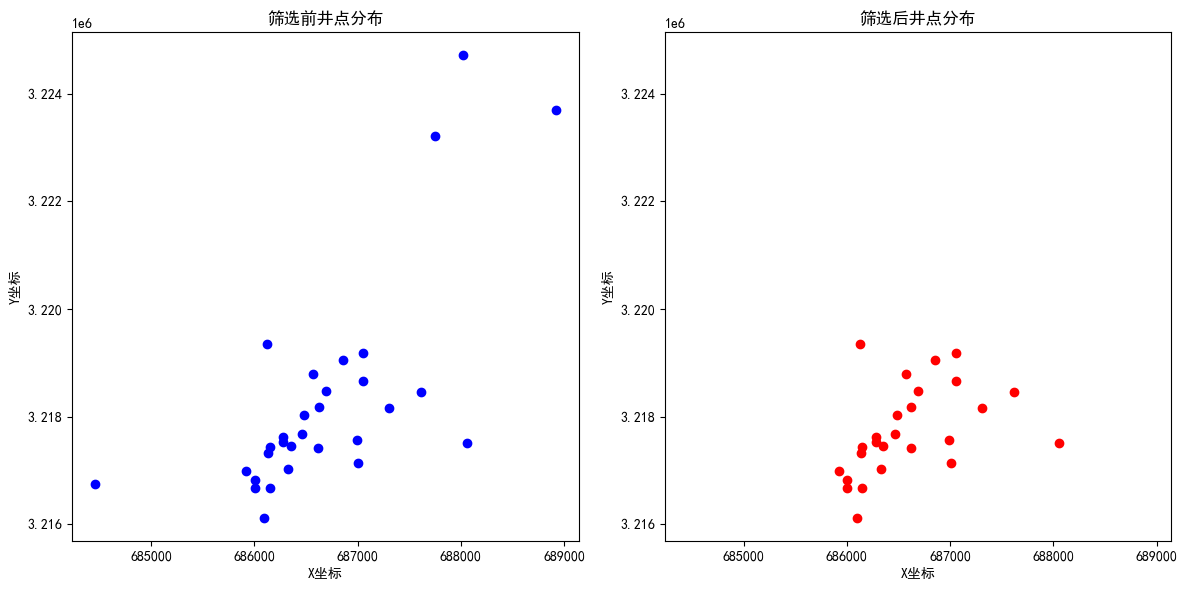

In [4]:
# 筛选离群井
data_well_purpose_surface_filtered = filter_outlier_wells(data_well_purpose_surface_position, method="iqr")

# 显示筛选前后的井点数量
print(f"筛选前井点数量: {len(data_well_purpose_surface_position)}")
print(f"筛选后井点数量: {len(data_well_purpose_surface_filtered)}")

# 可视化筛选前后的井点分布
plt.figure(figsize=(12, 6))

# 计算坐标范围（使用所有井点的数据来确定范围）
x_min = data_well_purpose_surface_position["X"].min()
x_max = data_well_purpose_surface_position["X"].max()
y_min = data_well_purpose_surface_position["Y"].min()
y_max = data_well_purpose_surface_position["Y"].max()

# 可选：添加一些边距使图更美观
margin = 0.05  # 5%的边距
x_range = x_max - x_min
y_range = y_max - y_min
x_min -= x_range * margin
x_max += x_range * margin
y_min -= y_range * margin
y_max += y_range * margin

# 绘制筛选前的井点分布
plt.subplot(1, 2, 1)
plt.scatter(data_well_purpose_surface_position["X"], data_well_purpose_surface_position["Y"], c="blue")
plt.title("筛选前井点分布")
plt.xlabel("X坐标")
plt.ylabel("Y坐标")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# 绘制筛选后的井点分布
plt.subplot(1, 2, 2)
plt.scatter(data_well_purpose_surface_filtered["X"], data_well_purpose_surface_filtered["Y"], c="red")
plt.title("筛选后井点分布")
plt.xlabel("X坐标")
plt.ylabel("Y坐标")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "well_filtering_comparison.png"))
plt.show()

## 处理属性缺失值


In [5]:
# 首先获取地震属性列表
attribute_names, _ = identify_attributes(os.path.join(data_dir, "H6-2_attr"))

# 使用preprocess_features处理地震数据
processed_seismic, attr_stats = preprocess_features(
    data=data_seismic_attr,
    attribute_columns=attribute_names,
    missing_values=[-999],
    missing_threshold=0.6,  # 缺失值超过60%的列将被删除
    outlier_method="iqr",
    outlier_threshold=1.5,
    verbose=True,
)

# 提取筛选后的属性
attribute_names_filtered = [col for col in processed_seismic.columns]

# 将处理后的属性数据与原始坐标数据合并
processed_seismic_full = data_seismic_attr[["X", "Y"]].copy()
for col in processed_seismic.columns:
    processed_seismic_full[col] = processed_seismic[col]

正在识别文件属性: ..\data\H6-2_attr
识别到 END ATTRIBUTES 位于第 31 行
识别到 15 个属性:
  - Average energy
  - Average envelope
  - Average instantaneous frequency
  - Average instantaneous phase
  - Average peak value
  - Geometric mean
  - Half energy
  - Harmonic mean
  - Maximum amplitude
  - Mean amplitude
  - Minimum amplitude
  - Most of
  - RMS amplitude
  - Sum of amplitudes
  - Sum of energy
处理前特征: (51714, 15)

每列缺失值情况:
  - Average energy: 0 (0.00%)
  - Average envelope: 0 (0.00%)
  - Average instantaneous frequency: 0 (0.00%)
  - Average instantaneous phase: 0 (0.00%)
  - Average peak value: 36625 (70.82%)
  - Geometric mean: 44667 (86.37%)
  - Half energy: 0 (0.00%)
  - Harmonic mean: 0 (0.00%)
  - Maximum amplitude: 225 (0.44%)
  - Mean amplitude: 0 (0.00%)
  - Minimum amplitude: 197 (0.38%)
  - Most of: 0 (0.00%)
  - RMS amplitude: 0 (0.00%)
  - Sum of amplitudes: 0 (0.00%)
  - Sum of energy: 0 (0.00%)

删除以下缺失值比例 >= 60.0% 的列: ['Average peak value', 'Geometric mean']
  - 属性 'Average energy'的填

## 根据井点分布，缩小工区范围


井点数据X轴范围: 685921.10 到 688057.00
井点数据Y轴范围: 3216119.60 到 3219350.50
原始地震数据点数: 51714
缩小范围后的地震数据点数: 6208
数据量减少了: 88.00%


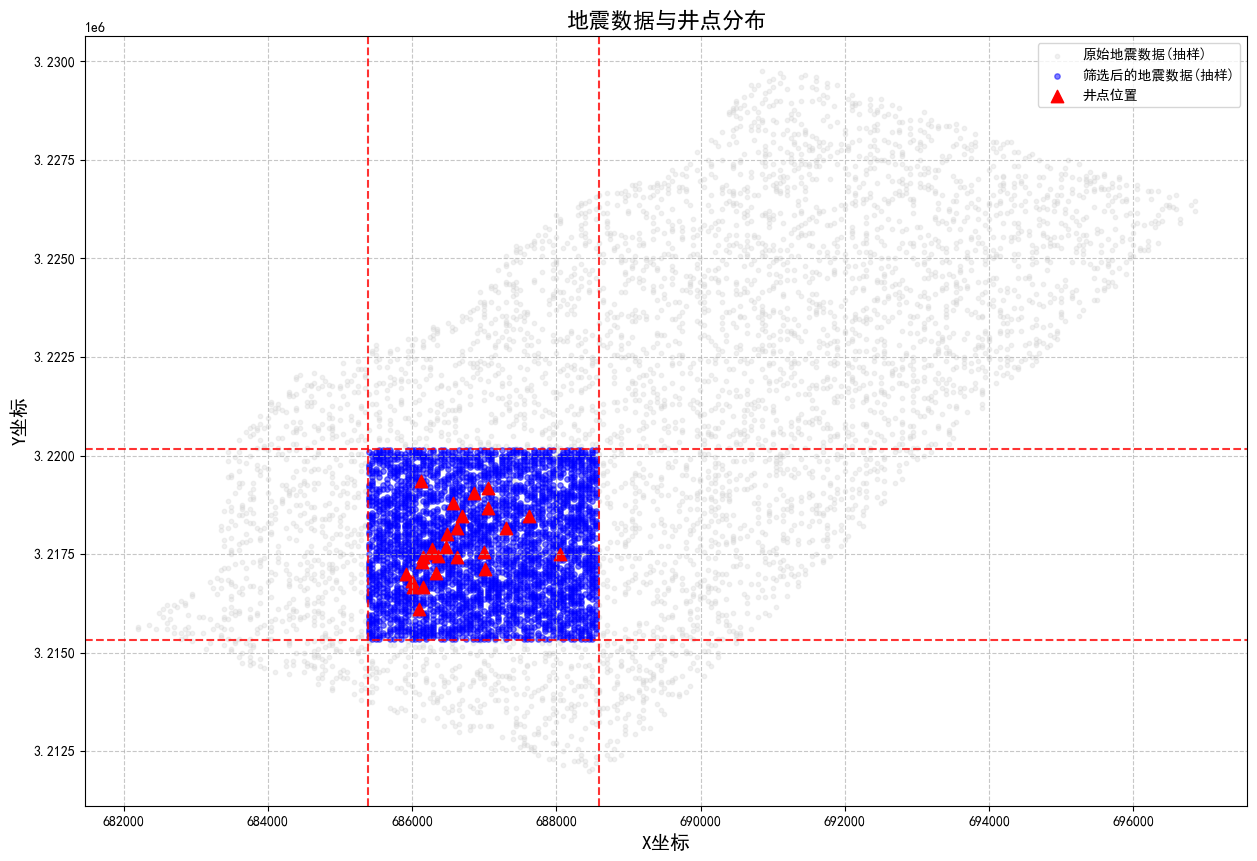

区域边界信息:
  x_min: 685387.125
  x_max: 688590.975
  y_min: 3215311.875
  y_max: 3220158.225
  x_center: 686989.05
  y_center: 3217735.05
  expansion_factor: 1.5


In [6]:
# 限制工区范围
seismic_attr_filtered, area_bounds = filter_seismic_by_wells(
    seismic_data=processed_seismic_full,
    well_data=data_well_purpose_surface_filtered,
    expansion_factor=1.5,  # 扩展50%
    plot=True,
    output_dir=output_dir,
)

# 后续可以直接使用area_bounds中的边界信息
print("区域边界信息:")
for key, value in area_bounds.items():
    print(f"  {key}: {value}")

## 提取井点处地震属性


In [7]:
# 为筛选前的井点提取地震属性
well_attr = extract_seismic_attributes_for_wells(
    well_data=data_well_purpose_surface_position,
    seismic_data=processed_seismic_full,
    max_distance=50,
    num_points=5,
)

# 为筛选后的井点提取地震属性
well_attr_filtered = extract_seismic_attributes_for_wells(
    well_data=data_well_purpose_surface_filtered, seismic_data=processed_seismic_full, max_distance=50, num_points=5
)

# 保存处理结果
well_attr.to_excel(os.path.join(data_dir, "wells_attr.xlsx"), index=False)
print("筛选前井点的地震属性已保存到 wells_attr.xlsx")
well_attr_filtered.to_excel(os.path.join(data_dir, "wells_attr_filtered.xlsx"), index=False)
print("筛选后井点的地震属性已保存到 wells_attr_filtered.xlsx")

筛选前井点的地震属性已保存到 wells_attr.xlsx
筛选后井点的地震属性已保存到 wells_attr_filtered.xlsx


## 生成统计摘要


In [8]:
# 筛选出质量良好的属性
good_attributes, anomalous_attributes, attribute_stats = filter_anomalous_attributes(
    seismic_data=seismic_attr_filtered,
    well_data=well_attr_filtered,
    common_attributes=attribute_names_filtered,
    ratio_threshold=5.0,  # 均值比值阈值
    range_ratio_threshold=10.0,  # 数值范围比值阈值
    std_ratio_threshold=10.0,  # 标准差比值阈值
    output_dir=None,  # 输出图表目录
    verbose=True,  # 打印详细信息
)

print("\n筛选后保留的质量良好属性:")
for attr in good_attributes:
    print(f"- {attr}")

======== 井点数据与地震数据的属性统计比较 ========

共分析了 13 个共同属性
发现 2 个异常属性
保留 11 个质量良好的属性

异常属性及原因:
  - Harmonic mean: 标准差比值异常 (272.2503), 数值范围比值异常 (5819.9082)
  - Mean amplitude: 均值比值为负 (-1.2599)

筛选后保留的质量良好属性:
- Average instantaneous phase
- Sum of amplitudes
- Sum of energy
- Minimum amplitude
- Most of
- Maximum amplitude
- Average energy
- Average envelope
- Average instantaneous frequency
- Half energy
- RMS amplitude


## 随机森林重要性和相关性分析


======== 多次运行随机森林特征重要性分析 ========

运行 1/10
模型性能: MSE = 36.3748, R² = 0.4023

运行 2/10
模型性能: MSE = 55.9795, R² = 0.2294

运行 3/10
模型性能: MSE = 7.5749, R² = 0.4199

运行 4/10
模型性能: MSE = 12.9303, R² = 0.0519

运行 5/10
模型性能: MSE = 16.4447, R² = -0.3650

运行 6/10
模型性能: MSE = 66.5081, R² = 0.2281

运行 7/10
模型性能: MSE = 36.7221, R² = 0.1745

运行 8/10
模型性能: MSE = 30.7438, R² = 0.4870

运行 9/10
模型性能: MSE = 46.5974, R² = 0.2045

运行 10/10
模型性能: MSE = 8.8993, R² = -0.0140

特征平均排名和稳定性:
Minimum amplitude: 平均排名 = 1.10, 排名标准差 = 0.30, 平均重要性 = 0.358008
Most of: 平均排名 = 3.20, 排名标准差 = 1.83, 平均重要性 = 0.127526
Half energy: 平均排名 = 3.90, 排名标准差 = 2.59, 平均重要性 = 0.110857
Sum of amplitudes: 平均排名 = 5.30, 排名标准差 = 2.05, 平均重要性 = 0.065904
Sum of energy: 平均排名 = 5.30, 排名标准差 = 2.19, 平均重要性 = 0.079912
Average instantaneous phase: 平均排名 = 5.50, 排名标准差 = 2.16, 平均重要性 = 0.078466
Maximum amplitude: 平均排名 = 6.40, 排名标准差 = 1.74, 平均重要性 = 0.054229
Average energy: 平均排名 = 7.90, 排名标准差 = 1.76, 平均重要性 = 0.037429
Average instantaneous frequency: 平均排名 = 8

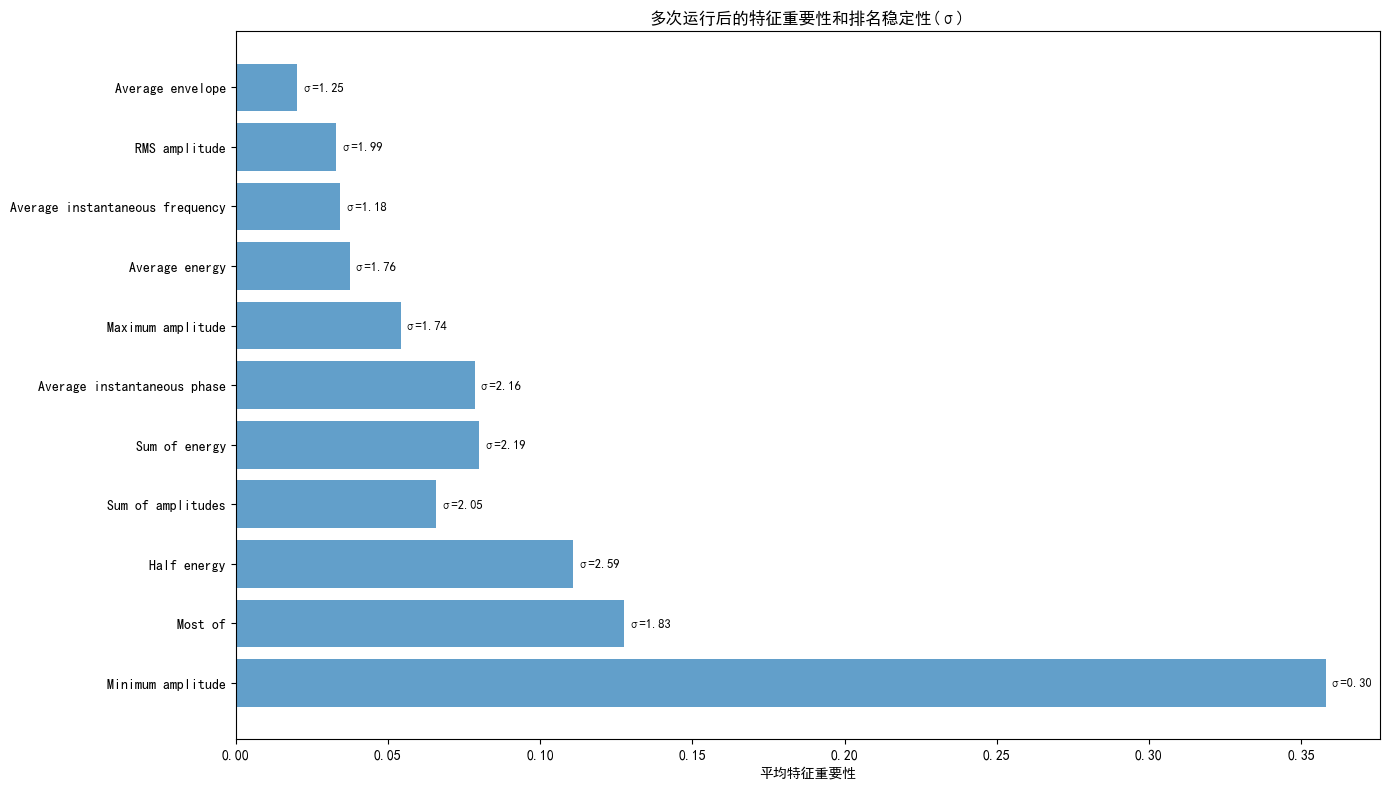

添加特征: Minimum amplitude (平均排名: 1.10, 排名稳定性: 0.30)
特征 'Most of' 与已选特征 'Minimum amplitude' 相关性过高 (0.9686)，被视为冗余
添加特征: Half energy (平均排名: 3.90, 排名稳定性: 2.59)
添加特征: Sum of amplitudes (平均排名: 5.30, 排名稳定性: 2.05)


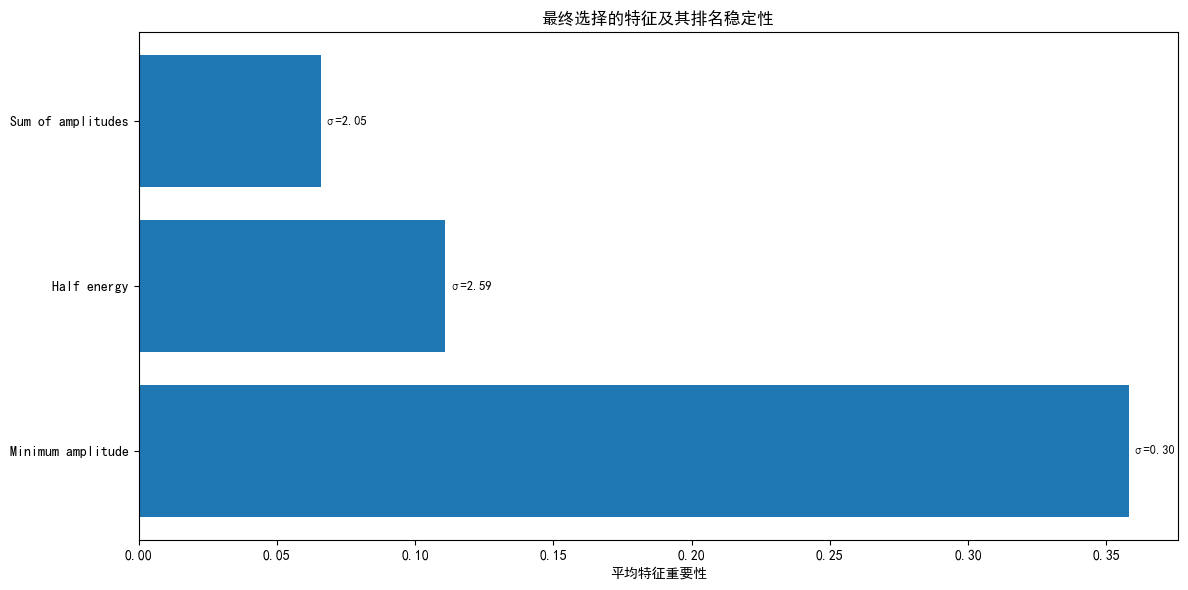


最终选择的特征列表:
1. Minimum amplitude: 平均排名 = 1.10, 排名稳定性 = 0.30
2. Half energy: 平均排名 = 3.90, 排名稳定性 = 2.59
3. Sum of amplitudes: 平均排名 = 5.30, 排名稳定性 = 2.05

共选择了 3 个特征用于建模
======== 特征选择分析完成 ========

基于随机森林重要性和相关性分析的最佳特征:
1. Minimum amplitude
2. Half energy
3. Sum of amplitudes


In [9]:
# 使用随机森林评估特征重要性并移除冗余特征
selected_features = select_best_features(
    well_data=well_attr_filtered,
    attribute_columns=good_attributes,
    target_column="Sand Thickness",
    n_features=3,
    corr_threshold=0.85,
    output_dir=output_dir,
    verbose=True,
)

# 输出特征选择结果
print("\n基于随机森林重要性和相关性分析的最佳特征:")
for i, feature in enumerate(selected_features):
    print(f"{i + 1}. {feature}")

## 提取样本，准备设置虚拟井


采样区域范围: X=[685387.12, 688590.97], Y=[3215311.88, 3220158.23]
指定区域内的地震数据点数: 6208 / 6208 (100.00%)
生成了 1600 个等间距采样点 (40行 x 40列)
最近距离统计: 最小=1.59, 最大=58.77, 平均=20.24, 中位数=20.04
最终返回 1600 个采样点


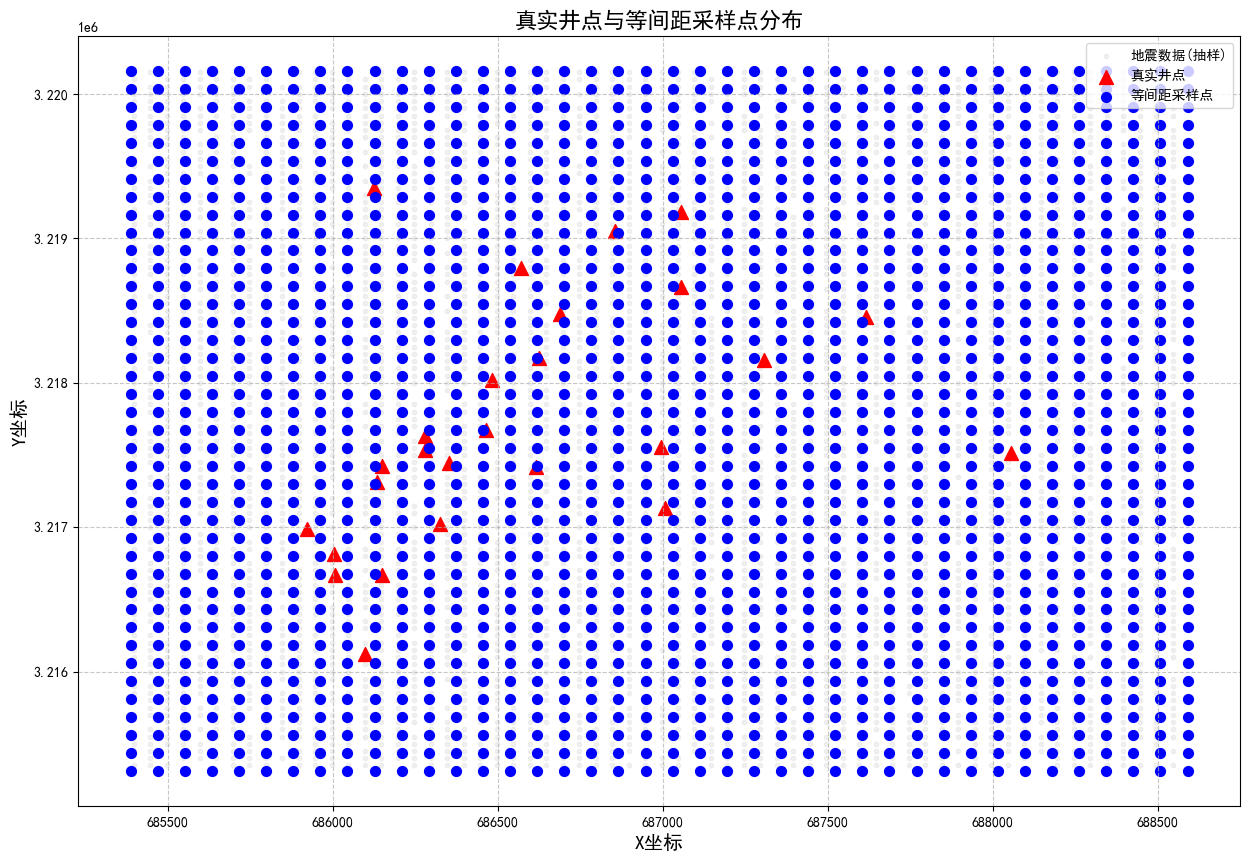

等间距地震样本数据已保存至 output\seismic_samples.csv


In [10]:
# 使用筛选后的地震数据区域提取等间距样本
seismic_samples = extract_uniform_seismic_samples(
    seismic_data=seismic_attr_filtered,
    n_rows=40,
    n_cols=40,
    area_bounds=area_bounds,  # 直接传入边界字典
)

# 可视化真实井点和采样点
plt.figure(figsize=(15, 10))

# 绘制地震数据点（使用抽样）
sample_ratio = min(1.0, 5000 / len(seismic_attr_filtered))
seismic_sample = seismic_attr_filtered.sample(frac=sample_ratio)
plt.scatter(seismic_sample["X"], seismic_sample["Y"], color="lightgray", alpha=0.3, s=10, label="地震数据(抽样)")

# 绘制真实井点位置
plt.scatter(well_attr_filtered["X"], well_attr_filtered["Y"], color="red", s=100, marker="^", label="真实井点")

# 绘制等间距采样点位置
plt.scatter(seismic_samples["X"], seismic_samples["Y"], color="blue", s=50, marker="o", label="等间距采样点")

# 添加标题和图例
plt.title("真实井点与等间距采样点分布", fontsize=16)
plt.xlabel("X坐标", fontsize=14)
plt.ylabel("Y坐标", fontsize=14)
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.7)

# 保存图片
plt.savefig(os.path.join(output_dir, "real_wells_and_seismic_samples.png"), dpi=300, bbox_inches="tight")
plt.show()


# 保存提取的样本数据
seismic_samples.to_csv(os.path.join(output_dir, "seismic_samples.csv"), index=False)
print(f"等间距地震样本数据已保存至 {os.path.join(output_dir, 'seismic_samples.csv')}")

## 多线性模型一致性预测设置虚拟井


In [11]:
# 创建融合属性和多模型预测
print("======== 创建融合属性和多模型预测 ========")
target_column = "Sand Thickness"
min_corr_threshold = 0.3  # 最小相关性阈值，低于此值的属性将被排除

# 准备训练数据
X_labeled = well_attr_filtered[selected_features].values
y_labeled = well_attr_filtered[target_column].values

# 准备未标记数据（地震样本点）
X_unlabeled = seismic_samples[selected_features].dropna().values
unlabeled_indices = seismic_samples[selected_features].dropna().index

# 1. 融合属性线性加权预测
print("\n=== 模型1: 融合属性线性加权 ===")

# 计算相关性权重
correlation_weights = {}
for i, feature in enumerate(selected_features):
    corr, _ = pearsonr(well_attr_filtered[feature], well_attr_filtered[target_column])
    if abs(corr) >= min_corr_threshold:
        correlation_weights[feature] = corr
        print(f"属性 '{feature}' 与砂厚的 Pearson 相关性: {corr:.4f}")
    else:
        print(f"属性 '{feature}' 与砂厚的相关性过低 ({corr:.4f})，不纳入融合")

# 如果没有有效属性，使用所有属性且权重相等
if len(correlation_weights) == 0:
    print("警告: 没有属性满足相关性阈值，将使用所有属性且权重相等")
    for feature in selected_features:
        correlation_weights[feature] = 1.0
        print(f"属性 '{feature}' 使用默认权重: 1.0")

# 标准化数据
scaler = StandardScaler()
X_labeled_scaled = scaler.fit_transform(X_labeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled)


# 创建融合属性函数
def create_fused_attribute(X_scaled, features, weights):
    """
    基于选定特征和权重创建融合属性

    参数:
        X_scaled (ndarray): 标准化后的特征矩阵
        features (list): 特征列表
        weights (dict): 每个特征的权重

    返回:
        ndarray: 融合属性
    """
    # 初始化融合属性
    fused_attr = np.zeros(X_scaled.shape[0])
    weight_sum = 0

    # 对每个特征进行加权融合
    for i, feature in enumerate(features):
        if feature in weights:
            weight = weights[feature]
            fused_attr += X_scaled[:, i] * weight
            weight_sum += abs(weight)

    # 归一化融合结果
    if weight_sum > 0:
        fused_attr /= weight_sum

    return fused_attr


# 在训练数据上创建融合属性
fused_attr_labeled = create_fused_attribute(X_labeled_scaled, selected_features, correlation_weights)

# 在未标记数据上创建融合属性
fused_attr_unlabeled = create_fused_attribute(X_unlabeled_scaled, selected_features, correlation_weights)

# 使用融合属性拟合线性回归
linear_model = LinearRegression()
linear_model.fit(fused_attr_labeled.reshape(-1, 1), y_labeled)

# 预测
fused_pred_labeled = linear_model.predict(fused_attr_labeled.reshape(-1, 1))
fused_pred_unlabeled = linear_model.predict(fused_attr_unlabeled.reshape(-1, 1))

# 评估融合属性预测效果
fused_corr = np.corrcoef(fused_pred_labeled, y_labeled)[0, 1]
print(f"融合属性预测结果与真实砂厚的相关性: {fused_corr:.4f}")

# 2. Lasso回归 + Bootstrap
print("\n=== 模型2: LassoCV + Bootstrap ===")

n_bootstrap = 100  # Bootstrap重采样次数
alpha_values = np.logspace(-4, 1, 30)  # alpha候选值

# 主Lasso模型
lasso_model = LassoCV(alphas=alpha_values, cv=5, max_iter=10000, tol=1e-3)
lasso_model.fit(X_labeled_scaled, y_labeled)
print(f"Lasso最优alpha值: {lasso_model.alpha_:.6f}")

# 在训练数据上的预测
lasso_pred_labeled = lasso_model.predict(X_labeled_scaled)
lasso_corr = np.corrcoef(lasso_pred_labeled, y_labeled)[0, 1]
print(f"Lasso预测结果与真实砂厚的相关性: {lasso_corr:.4f}")

# Bootstrap重采样预测
lasso_bootstrap_preds = np.zeros((n_bootstrap, X_unlabeled_scaled.shape[0]))

for i in range(n_bootstrap):
    # Bootstrap重采样
    indices = np.random.choice(len(X_labeled_scaled), len(X_labeled_scaled), replace=True)
    X_boot, y_boot = X_labeled_scaled[indices], y_labeled[indices]

    # 拟合模型
    lasso_boot = LassoCV(alphas=alpha_values, cv=5, max_iter=10000, tol=1e-3)
    lasso_boot.fit(X_boot, y_boot)

    # 预测
    lasso_bootstrap_preds[i, :] = lasso_boot.predict(X_unlabeled_scaled)

# 计算预测均值和置信区间
lasso_pred_unlabeled = np.mean(lasso_bootstrap_preds, axis=0)
lasso_lower_ci = np.percentile(lasso_bootstrap_preds, 2.5, axis=0)
lasso_upper_ci = np.percentile(lasso_bootstrap_preds, 97.5, axis=0)

# 3. Ridge回归 + Bootstrap
print("\n=== 模型3: RidgeCV + Bootstrap ===")

alpha_values = np.logspace(-3, 3, 30)  # alpha候选值

# 主Ridge模型
ridge_model = RidgeCV(alphas=alpha_values, cv=5)
ridge_model.fit(X_labeled_scaled, y_labeled)
print(f"Ridge最优alpha值: {ridge_model.alpha_:.6f}")

# 在训练数据上的预测
ridge_pred_labeled = ridge_model.predict(X_labeled_scaled)
ridge_corr = np.corrcoef(ridge_pred_labeled, y_labeled)[0, 1]
print(f"Ridge预测结果与真实砂厚的相关性: {ridge_corr:.4f}")

# Bootstrap重采样预测
ridge_bootstrap_preds = np.zeros((n_bootstrap, X_unlabeled_scaled.shape[0]))

for i in range(n_bootstrap):
    # Bootstrap重采样
    indices = np.random.choice(len(X_labeled_scaled), len(X_labeled_scaled), replace=True)
    X_boot, y_boot = X_labeled_scaled[indices], y_labeled[indices]

    # 拟合模型
    ridge_boot = RidgeCV(alphas=alpha_values, cv=5)
    ridge_boot.fit(X_boot, y_boot)

    # 预测
    ridge_bootstrap_preds[i, :] = ridge_boot.predict(X_unlabeled_scaled)

# 计算预测均值和置信区间
ridge_pred_unlabeled = np.mean(ridge_bootstrap_preds, axis=0)
ridge_lower_ci = np.percentile(ridge_bootstrap_preds, 2.5, axis=0)
ridge_upper_ci = np.percentile(ridge_bootstrap_preds, 97.5, axis=0)

======== 创建融合属性和多模型预测 ========

=== 模型1: 融合属性线性加权 ===
属性 'Minimum amplitude' 与砂厚的 Pearson 相关性: -0.7452
属性 'Half energy' 与砂厚的相关性过低 (-0.1428)，不纳入融合
属性 'Sum of amplitudes' 与砂厚的相关性过低 (0.0577)，不纳入融合
融合属性预测结果与真实砂厚的相关性: 0.7452

=== 模型2: LassoCV + Bootstrap ===
Lasso最优alpha值: 0.188739
Lasso预测结果与真实砂厚的相关性: 0.8287

=== 模型3: RidgeCV + Bootstrap ===
Ridge最优alpha值: 5.298317
Ridge预测结果与真实砂厚的相关性: 0.8279


## 平衡区间分布与质量控制的伪样本筛选


In [12]:
def calculate_quality_score(mean_pred, max_diff, rel_diff, lasso_std, ridge_std, thresholds):
    """
    计算样本的质量分数（0-1，越高越好）

    参数:
        mean_pred: 平均预测值
        max_diff: 最大模型差异
        rel_diff: 相对差异
        lasso_std: Lasso模型标准差
        ridge_std: Ridge模型标准差
        thresholds: 包含各阈值的字典
    """
    # 基础权重
    w_consistency = thresholds["w_consistency"]  # 一致性权重
    w_uncertainty = thresholds["w_uncertainty"]  # 不确定性权重

    # 计算一致性得分 (0-1)
    abs_score = max(0, 1 - max_diff / thresholds["abs_threshold"])
    rel_score = max(0, 1 - rel_diff / thresholds["rel_threshold"])
    consistency_score = 0.5 * abs_score + 0.5 * rel_score

    # 计算不确定性得分 (0-1)
    lasso_std_score = max(0, 1 - lasso_std / thresholds["std_threshold"])
    ridge_std_score = max(0, 1 - ridge_std / thresholds["std_threshold"])
    uncertainty_score = 0.5 * lasso_std_score + 0.5 * ridge_std_score

    # 组合得分
    final_score = w_consistency * consistency_score + w_uncertainty * uncertainty_score

    return final_score


def calculate_j_score(selected_indices, quality_scores, mean_preds, target_dist, bins, thresholds):
    """计算当前选择的J评分"""
    if len(selected_indices) == 0:
        return 0

    # 1. 计算质量分数
    selected_quality = quality_scores[selected_indices]
    Q_total = np.mean(selected_quality)

    # 2. 计算分布相似度
    selected_values = mean_preds[selected_indices]
    hist, _ = np.histogram(selected_values, bins=bins)
    current_dist = hist / (np.sum(hist) + 1e-10)

    # Jensen-Shannon散度
    from scipy.spatial.distance import jensenshannon

    jsd = jensenshannon(current_dist, target_dist)
    dist_similarity = 1 - jsd

    # 3. 计算样本数量得分
    n_samples = len(selected_indices)
    min_samples = 200
    max_samples = 1000
    quantity_score = min(1.0, max(0.0, (n_samples - min_samples) / (max_samples - min_samples)))

    # 计算J值 - 使用动态权重
    J = (
        thresholds["j_quality_weight"] * Q_total
        + thresholds["j_dist_weight"] * dist_similarity
        + thresholds["j_quantity_weight"] * quantity_score
    )

    return J

In [13]:
def get_dynamic_quality_threshold(bin_idx, sample_ratio, base_threshold):
    """
    基于区间特性和充足率的精细调整

    参数:
        bin_idx: 区间索引
        sample_ratio: 区间的当前样本充足率
        base_threshold: 当前基础质量阈值
    """
    # 1. 区间特性调整
    if bin_idx >= 2:  # 高砂厚区间对质量更加宽容
        adjusted = max(0.3, base_threshold - 0.1)
    else:
        adjusted = base_threshold

    # 2. 样本充足率调整
    if sample_ratio < 0.3:  # 严重不足
        return max(0.3, adjusted - 0.1)
    elif sample_ratio < 0.6:  # 较为不足
        return max(0.35, adjusted - 0.05)
    else:  # 接近或超过目标
        return adjusted


def adjust_thresholds(thresholds, iteration, bin_coverage):
    """
    根据迭代情况全局调整下一轮迭代的阈值

    参数:
        thresholds: 当前阈值字典
        iteration: 当前迭代次数
        bin_coverage: 各区间的样本覆盖率
    """
    new_thresholds = thresholds.copy()

    # 1. 根据迭代次数调整模型差异容忍度参数
    iteration_factor = min(1.5, 1.0 + iteration * 0.05)  # 每次迭代增加5%，最多增加50%
    new_thresholds["abs_threshold"] *= iteration_factor
    new_thresholds["rel_threshold"] *= iteration_factor
    new_thresholds["std_threshold"] *= iteration_factor

    # 2. 根据迭代次数调整基础质量阈值
    # 随着迭代进行，逐渐降低基础质量要求
    if iteration > 0:
        new_quality = max(0.3, thresholds["min_quality"] * (1 - iteration * 0.05))
        new_thresholds["min_quality"] = new_quality

    # 3. 根据总体覆盖情况调整J评分权重
    min_coverage = np.min(bin_coverage)
    if min_coverage < 0.3:  # 覆盖率极低
        # 降低分布权重，更关注质量和数量
        new_thresholds["j_dist_weight"] *= 0.85
        new_thresholds["j_quality_weight"] = 1 - new_thresholds["j_dist_weight"] - new_thresholds["j_quantity_weight"]

    # 保证权重和为1
    total_weight = (
        new_thresholds["j_quality_weight"] + new_thresholds["j_dist_weight"] + new_thresholds["j_quantity_weight"]
    )
    if total_weight != 1.0:
        new_thresholds["j_quality_weight"] /= total_weight
        new_thresholds["j_dist_weight"] /= total_weight
        new_thresholds["j_quantity_weight"] /= total_weight

    # 4. 调整J评分容忍度
    new_thresholds["j_tolerance"] = min(0.1, 0.01 + iteration * 0.02)  # 每次迭代增加0.02，最大0.1

    return new_thresholds


=== 平衡分布与质量控制的优化采样 ===

预处理：排除靠近真实井点且砂厚差异大的点...
  排除了 56 个靠近真实井点且砂厚差异大的点
  - 显示前10个排除原因:
    点248(预测砂厚=9.96)与井点16(真实砂厚=11.81)距离80.9米，差异1.85米
    点249(预测砂厚=12.73)与井点16(真实砂厚=11.81)距离69.1米，差异0.92米
    点288(预测砂厚=10.05)与井点16(真实砂厚=11.81)距离80.9米，差异1.76米
    点289(预测砂厚=11.64)与井点16(真实砂厚=11.81)距离69.1米，差异0.17米
    点447(预测砂厚=0.00)与井点10(真实砂厚=0.63)距离44.8米，差异0.63米
    点448(预测砂厚=1.41)与井点10(真实砂厚=0.63)距离40.0米，差异0.78米
    点449(预测砂厚=5.73)与井点3(真实砂厚=0.75)距离26.6米，差异4.98米
    点450(预测砂厚=5.40)与井点3(真实砂厚=0.75)距离60.6米，差异4.65米
    点488(预测砂厚=1.20)与井点11(真实砂厚=0.00)距离43.4米，差异1.20米
    点527(预测砂厚=0.61)与井点4(真实砂厚=0.00)距离71.8米，差异0.61米
  预处理后剩余 1544 个有效点 (排除了 56 个点)

各砂厚区间原始分布:
  0-0.1: 320个 (20.7%)
  0.1-10: 1057个 (68.5%)
  >10: 167个 (10.8%)

目标样本分布:
  0-0.1: 目标123个样本 (39.9%)
  0.1-10: 目标123个样本 (39.9%)
  >10: 目标62个样本 (20.1%)

开始迭代优化样本选择...

迭代 1/10
当前阈值设置:
  abs_threshold: 3.0000
  rel_threshold: 0.2000
  std_threshold: 2.5000
  w_consistency: 0.6000
  w_uncertainty: 0.4000
  min_quality: 0.6000
  j_quality_weight: 0.6000
 

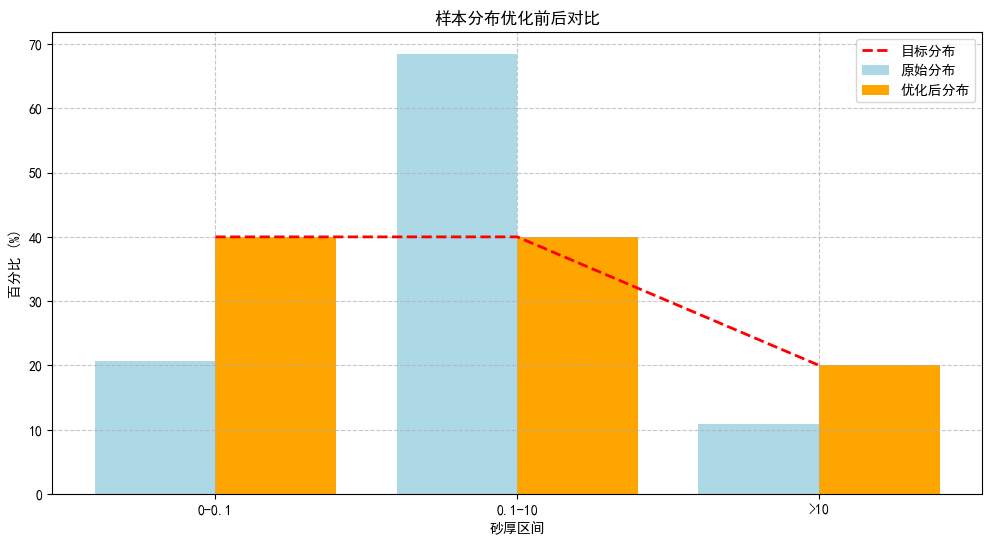


预测结果已保存至 output\seismic_samples_with_predictions.csv
优化后的虚拟井数据已保存至 output\optimized_pseudo_wells.csv

最终优化J评分: 0.6138


In [14]:
# 4. 平衡分布与质量控制的优化采样
print("\n=== 平衡分布与质量控制的优化采样 ===")

# 将三个模型的预测结果整合
predictions = np.column_stack([fused_pred_unlabeled, lasso_pred_unlabeled, ridge_pred_unlabeled])

# 计算每个点三个预测值的最大差异
max_diffs = np.max(predictions, axis=1) - np.min(predictions, axis=1)

# 计算平均预测值用于相对差异计算
mean_preds = np.mean(predictions, axis=1)

# 预先处理预测值，将负值替换为0
mean_preds = np.maximum(mean_preds, 0)
fused_pred_unlabeled = np.maximum(fused_pred_unlabeled, 0)
lasso_pred_unlabeled = np.maximum(lasso_pred_unlabeled, 0)
ridge_pred_unlabeled = np.maximum(ridge_pred_unlabeled, 0)

# 计算bootstrap结果的标准差
lasso_std = np.std(lasso_bootstrap_preds, axis=0)
ridge_std = np.std(ridge_bootstrap_preds, axis=0)

# 定义砂厚区间
bins = [0, 0.1, 10, np.inf]
bin_labels = ["0-0.1", "0.1-10", ">10"]

# 排除靠近真实井点且砂厚差异大的点
print("\n预处理：排除靠近真实井点且砂厚差异大的点...")
valid_unlabeled_mask = np.ones(len(unlabeled_indices), dtype=bool)
proximity_radius = 100  # 米，设置排除半径
max_thickness_diff = 0.1  # 米，最大允许砂厚差异

# 获取真实井点的坐标和砂厚
real_well_x = well_attr_filtered["X"].values
real_well_y = well_attr_filtered["Y"].values
real_well_thickness = well_attr_filtered["Sand Thickness"].values

# 获取未标记点的坐标
unlabeled_x = seismic_samples.loc[unlabeled_indices, "X"].values
unlabeled_y = seismic_samples.loc[unlabeled_indices, "Y"].values

excluded_count = 0
excluded_reasons = []

# 逐个检查未标记点与真实井点的距离和砂厚差异
for i in range(len(unlabeled_indices)):
    for j in range(len(real_well_x)):
        # 计算距离
        distance = np.sqrt((unlabeled_x[i] - real_well_x[j]) ** 2 + (unlabeled_y[i] - real_well_y[j]) ** 2)

        # 如果距离小于排除半径
        if distance <= proximity_radius:
            # 计算砂厚差异
            thickness_diff = abs(mean_preds[i] - real_well_thickness[j])

            # 如果差异超过阈值，排除该点
            if thickness_diff > max_thickness_diff:
                valid_unlabeled_mask[i] = False
                excluded_count += 1
                excluded_reasons.append(
                    f"点{i}(预测砂厚={mean_preds[i]:.2f})与井点{j}(真实砂厚={real_well_thickness[j]:.2f})距离{distance:.1f}米，差异{thickness_diff:.2f}米"
                )
                break  # 一旦与任何真实井点冲突，就排除该点

if excluded_count > 0:
    print(f"  排除了 {excluded_count} 个靠近真实井点且砂厚差异大的点")
    if excluded_count <= 10:  # 只显示少量详情以避免日志过长
        for reason in excluded_reasons:
            print(f"  - {reason}")
    else:
        print(f"  - 显示前10个排除原因:")
        for reason in excluded_reasons[:10]:
            print(f"    {reason}")

# 更新有效的未标记索引和预测
valid_unlabeled_indices = unlabeled_indices[valid_unlabeled_mask]
valid_mean_preds = mean_preds[valid_unlabeled_mask]
valid_max_diffs = max_diffs[valid_unlabeled_mask]
valid_lasso_std = lasso_std[valid_unlabeled_mask]
valid_ridge_std = ridge_std[valid_unlabeled_mask]
valid_rel_diffs = valid_max_diffs / (valid_mean_preds + 1e-10)  # 避免除零

print(f"  预处理后剩余 {len(valid_unlabeled_indices)} 个有效点 (排除了 {excluded_count} 个点)")

# 将预测结果分配到各个区间
bin_indices = []
for i in range(len(bins) - 1):
    mask = (valid_mean_preds >= bins[i]) & (valid_mean_preds < bins[i + 1])
    bin_indices.append(np.where(mask)[0])

# 计算各区间样本数量
bin_counts = [len(indices) for indices in bin_indices]
print("\n各砂厚区间原始分布:")
for i, count in enumerate(bin_counts):
    print(f"  {bin_labels[i]}: {count}个 ({count / len(valid_mean_preds) * 100:.1f}%)")

# 设定目标分布
target_distribution = np.array([0.4, 0.4, 0.20])

# 目标样本总数（最小200个）
target_total_samples = max(200, int(0.2 * len(valid_mean_preds)))
min_samples_per_bin = 15  # 每个区间的最小样本数

# 计算每个区间的目标样本数
target_bin_samples = np.round(target_distribution * target_total_samples).astype(int)
# 确保每个区间至少有最小样本数
target_bin_samples = np.maximum(target_bin_samples, min_samples_per_bin)
# 调整以匹配总目标
target_bin_samples = np.round(target_bin_samples / sum(target_bin_samples) * target_total_samples).astype(int)

print("\n目标样本分布:")
for i, count in enumerate(target_bin_samples):
    print(f"  {bin_labels[i]}: 目标{count}个样本 ({count / sum(target_bin_samples) * 100:.1f}%)")

# 初始阈值设置
base_thresholds = {
    "abs_threshold": 3.0,  # 绝对差异阈值
    "rel_threshold": 0.2,  # 相对差异阈值
    "std_threshold": 2.5,  # 标准差阈值
    "w_consistency": 0.6,  # 一致性权重
    "w_uncertainty": 0.4,  # 不确定性权重
    "min_quality": 0.6,  # 最低质量阈值
    "j_quality_weight": 0.6,  # J评分中质量的权重
    "j_dist_weight": 0.25,  # J评分中分布的权重
    "j_quantity_weight": 0.15,  # J评分中数量的权重
    "j_tolerance": 0.01,  # J评分容忍度
}

# 计算所有样本的初始质量分数
quality_scores = np.zeros(len(valid_mean_preds))

for i in range(len(valid_mean_preds)):
    quality_scores[i] = calculate_quality_score(
        valid_mean_preds[i],
        valid_max_diffs[i],
        valid_rel_diffs[i],
        valid_lasso_std[i],
        valid_ridge_std[i],
        base_thresholds,
    )

# 迭代优化样本选择
print("\n开始迭代优化样本选择...")

# 初始化选择的样本
selected_indices = np.array([], dtype=int)
max_iterations = 10
current_j = 0
current_thresholds = base_thresholds.copy()
min_iterations = 3  # 至少运行的迭代次数

# 记录每次迭代的状态，用于调试和分析
iteration_history = []

for iteration in range(max_iterations):
    print(f"\n迭代 {iteration + 1}/{max_iterations}")

    # 打印当前阈值
    print("当前阈值设置:")
    for key, value in current_thresholds.items():
        print(f"  {key}: {value:.4f}")

    # 1. 重新计算质量分数(使用当前阈值)
    for i in range(len(valid_mean_preds)):
        quality_scores[i] = calculate_quality_score(
            valid_mean_preds[i],
            valid_max_diffs[i],
            valid_rel_diffs[i],
            valid_lasso_std[i],
            valid_ridge_std[i],
            current_thresholds,
        )

    # 2. 计算当前各区间已选样本数
    current_bin_samples = [0] * len(bin_labels)
    if len(selected_indices) > 0:
        selected_values = valid_mean_preds[selected_indices]
        for i in range(len(bins) - 1):
            current_bin_samples[i] = np.sum((selected_values >= bins[i]) & (selected_values < bins[i + 1]))

    # 3. 计算各区间的覆盖率
    bin_ratios = np.zeros(len(bins) - 1)
    for i in range(len(bins) - 1):
        bin_ratios[i] = current_bin_samples[i] / target_bin_samples[i] if target_bin_samples[i] > 0 else 1.0

    # 按照样本充足率排序区间（优先处理最不足的区间）
    bin_priority = np.argsort(bin_ratios)

    # 记录本次迭代前的状态
    pre_iteration_state = {
        "selected_count": len(selected_indices),
        "j_score": current_j,
        "bin_ratios": bin_ratios.copy(),
        "thresholds": current_thresholds.copy(),
    }

    improved = False

    # 4. 逐个处理各区间
    for bin_idx in bin_priority:
        # 如果该区间已经足够，并且不是第一轮迭代，可以跳过
        if bin_ratios[bin_idx] >= 1.0 and iteration > 0:
            print(f"  区间 {bin_labels[bin_idx]} 已达到目标覆盖率 ({bin_ratios[bin_idx] * 100:.1f}%)，跳过")
            continue

        # 5. 动态调整质量阈值
        quality_threshold = get_dynamic_quality_threshold(
            bin_idx=bin_idx, sample_ratio=bin_ratios[bin_idx], base_threshold=current_thresholds["min_quality"]
        )

        # 打印原始阈值和动态调整后的阈值，增强可理解性
        print(
            f"  处理区间 {bin_labels[bin_idx]} - 原始质量阈值={current_thresholds['min_quality']:.2f}, "
            f"动态调整后={quality_threshold:.2f}, 覆盖率={bin_ratios[bin_idx] * 100:.1f}%"
        )

        # 6. 获取该区间的候选样本
        candidates = bin_indices[bin_idx]

        # 排除已选择的样本
        candidates = np.setdiff1d(candidates, selected_indices)

        if len(candidates) == 0:
            print(f"  区间 {bin_labels[bin_idx]} 没有更多可用样本")
            continue

        # 7. 按质量排序
        candidates = candidates[np.argsort(-quality_scores[candidates])]

        # 8. 筛选符合质量要求的样本
        qualified_candidates = candidates[quality_scores[candidates] >= quality_threshold]

        if len(qualified_candidates) == 0:
            print(f"  区间 {bin_labels[bin_idx]} 没有符合质量要求(>{quality_threshold:.2f})的样本，跳过该区间")
            continue  # 不再尝试降低质量标准

        # 9. 计算需要添加的样本数
        needed = target_bin_samples[bin_idx] - current_bin_samples[bin_idx]
        to_add = min(needed, len(qualified_candidates))

        if to_add <= 0:
            print(f"  区间 {bin_labels[bin_idx]} 不需要添加更多样本")
            continue

        print(f"  尝试向区间 {bin_labels[bin_idx]} 添加 {to_add} 个样本 (质量阈值>{quality_threshold:.2f})")

        # 10. 添加样本并评估J值变化
        new_selected = (
            np.concatenate([selected_indices, qualified_candidates[:to_add]])
            if len(selected_indices) > 0
            else qualified_candidates[:to_add]
        )

        new_j = calculate_j_score(
            new_selected, quality_scores, valid_mean_preds, target_distribution, bins, current_thresholds
        )

        # 11. 评估J值变化
        j_tolerance = current_thresholds["j_tolerance"]
        j_change = new_j - current_j

        # 如果J值提高或在容忍范围内，接受新样本
        if new_j > current_j - j_tolerance or len(selected_indices) == 0:
            selected_indices = new_selected
            current_j = new_j
            improved = True

            print(f"  【接受】添加了 {to_add} 个样本，新J值: {current_j:.4f}")
            if j_change < 0:
                print(f"  注意: 接受了J值轻微下降({j_change:.4f})以获取更多样本")
        else:
            print(f"  【拒绝】J值下降超出容忍范围，不添加样本")

    # 记录本次迭代后的状态
    post_iteration_state = {"selected_count": len(selected_indices), "j_score": current_j, "improved": improved}

    iteration_history.append({**pre_iteration_state, **post_iteration_state})

    # 调整阈值，为下一轮迭代做准备
    current_thresholds = adjust_thresholds(current_thresholds, iteration + 1, bin_ratios)

    # 如果达到最小迭代次数且本轮迭代没有改进，考虑提前结束
    if iteration >= min_iterations and not improved:
        print(f"  已完成{iteration + 1}轮迭代且本轮无改进，提前结束")
        break

    # 打印当前状态
    if len(selected_indices) > 0:
        selected_values = valid_mean_preds[selected_indices]
        current_hist, _ = np.histogram(selected_values, bins=bins)
        print(f"  当前已选择 {len(selected_indices)} 个样本，J值 = {current_j:.4f}")
        for i in range(len(bins) - 1):
            coverage = current_hist[i] / target_bin_samples[i] * 100 if target_bin_samples[i] > 0 else 0
            print(
                f"    {bin_labels[i]}: {current_hist[i]}个 ({current_hist[i] / len(selected_indices) * 100:.1f}%), 目标覆盖率: {coverage:.1f}%"
            )

# 将选中的索引映射回原始索引
final_selected_indices_orig = valid_unlabeled_indices[selected_indices]

# 创建最终掩码
final_mask = np.zeros(len(unlabeled_indices), dtype=bool)
final_mask[np.where(np.isin(unlabeled_indices, final_selected_indices_orig))[0]] = True

# 统计最终结果
print("\n=== 最终样本选择结果 ===")
final_hist, _ = np.histogram(mean_preds[final_mask], bins=bins)
print(f"总计选择样本: {np.sum(final_mask)}个")
for i in range(len(bins) - 1):
    original_count = bin_counts[i]
    final_count = final_hist[i]
    coverage = final_count / target_bin_samples[i] * 100 if target_bin_samples[i] > 0 else 0
    print(
        f"砂厚范围 {bin_labels[i]}: {final_count}个 ({final_count / np.sum(final_mask) * 100:.1f}%) | "
        f"原始: {original_count}个 | 目标覆盖率: {coverage:.1f}%"
    )

# 统计最终质量分数
final_quality = quality_scores[selected_indices]
print(f"\n样本质量统计:")
print(f"  平均质量分数: {np.mean(final_quality):.4f}")
print(f"  最低质量分数: {np.min(final_quality):.4f}")
print(f"  最高质量分数: {np.max(final_quality):.4f}")

# 打印迭代历史摘要
print("\n迭代历史摘要:")
for i, hist in enumerate(iteration_history):
    print(f"  迭代 {i + 1}: 样本数 {hist['selected_count']}, J值 {hist['j_score']:.4f}")

# 创建伪标记数据
X_pseudo = X_unlabeled[final_mask]
y_pseudo = mean_preds[final_mask]

# 获取优化样本在原始seismic_samples中的索引
optimized_orig_indices = unlabeled_indices[final_mask]

# 添加预测结果到seismic_samples
seismic_samples["Fused_Pred"] = np.nan
seismic_samples["Lasso_Pred"] = np.nan
seismic_samples["Ridge_Pred"] = np.nan
seismic_samples["Mean_Pred"] = np.nan
seismic_samples["Max_Diff"] = np.nan
seismic_samples["Quality_Score"] = np.nan
seismic_samples["Is_Selected"] = False
seismic_samples["Excluded_By_Well"] = False  # 新增列：被真实井点排除

# 填充预测结果
seismic_samples.loc[unlabeled_indices, "Fused_Pred"] = fused_pred_unlabeled
seismic_samples.loc[unlabeled_indices, "Lasso_Pred"] = lasso_pred_unlabeled
seismic_samples.loc[unlabeled_indices, "Ridge_Pred"] = ridge_pred_unlabeled
seismic_samples.loc[unlabeled_indices, "Mean_Pred"] = mean_preds
seismic_samples.loc[unlabeled_indices, "Max_Diff"] = max_diffs
seismic_samples.loc[unlabeled_indices, "Quality_Score"] = np.nan  # 先设为NaN
seismic_samples.loc[valid_unlabeled_indices, "Quality_Score"] = quality_scores  # 只填充有效点的质量分数

# 标记被真实井点排除的点
excluded_indices = unlabeled_indices[~np.isin(unlabeled_indices, valid_unlabeled_indices)]
seismic_samples.loc[excluded_indices, "Excluded_By_Well"] = True

# 标记最终选择的点
seismic_samples.loc[optimized_orig_indices, "Is_Selected"] = True

# 统计并报告负值数量
neg_count = (seismic_samples["Mean_Pred"] < 0).sum()
if neg_count > 0:
    print(f"\n注意: 有 {neg_count} 个负的砂厚预测值已被替换为0")

# 将负数的Mean_Pred值置为0
seismic_samples["Mean_Pred"] = seismic_samples["Mean_Pred"].clip(lower=0)

# 可视化优化前后的分布变化
plt.figure(figsize=(12, 6))

# 原始分布
bin_percents = np.array(bin_counts) / sum(bin_counts) * 100
plt.bar(np.arange(len(bin_labels)) - 0.2, bin_percents, width=0.4, label="原始分布", color="lightblue")

# 优化后分布
optimized_percents = final_hist / sum(final_hist) * 100
plt.bar(np.arange(len(bin_labels)) + 0.2, optimized_percents, width=0.4, label="优化后分布", color="orange")

# 添加目标分布线
target_percents = target_distribution / sum(target_distribution) * 100
plt.plot(np.arange(len(bin_labels)), target_percents, "r--", label="目标分布", linewidth=2)

plt.xlabel("砂厚区间")
plt.ylabel("百分比 (%)")
plt.title("样本分布优化前后对比")
plt.xticks(np.arange(len(bin_labels)), bin_labels)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig(os.path.join(output_dir, "distribution_optimization.png"), dpi=300, bbox_inches="tight")
plt.show()

# 保存预测结果
seismic_samples.to_csv(os.path.join(output_dir, "seismic_samples_with_predictions.csv"), index=False)
print(f"\n预测结果已保存至 {os.path.join(output_dir, 'seismic_samples_with_predictions.csv')}")

# 保存优化后的虚拟井数据
optimized_samples = seismic_samples[seismic_samples["Is_Selected"] == True].copy()
optimized_samples.to_csv(os.path.join(output_dir, "optimized_pseudo_wells.csv"), index=False)
print(f"优化后的虚拟井数据已保存至 {os.path.join(output_dir, 'optimized_pseudo_wells.csv')}")

# 计算质量-分布的J指标
final_j = calculate_j_score(
    selected_indices, quality_scores, valid_mean_preds, target_distribution, bins, current_thresholds
)
print(f"\n最终优化J评分: {final_j:.4f}")

## 虚拟井展示


为整个小工区地震数据创建融合属性...


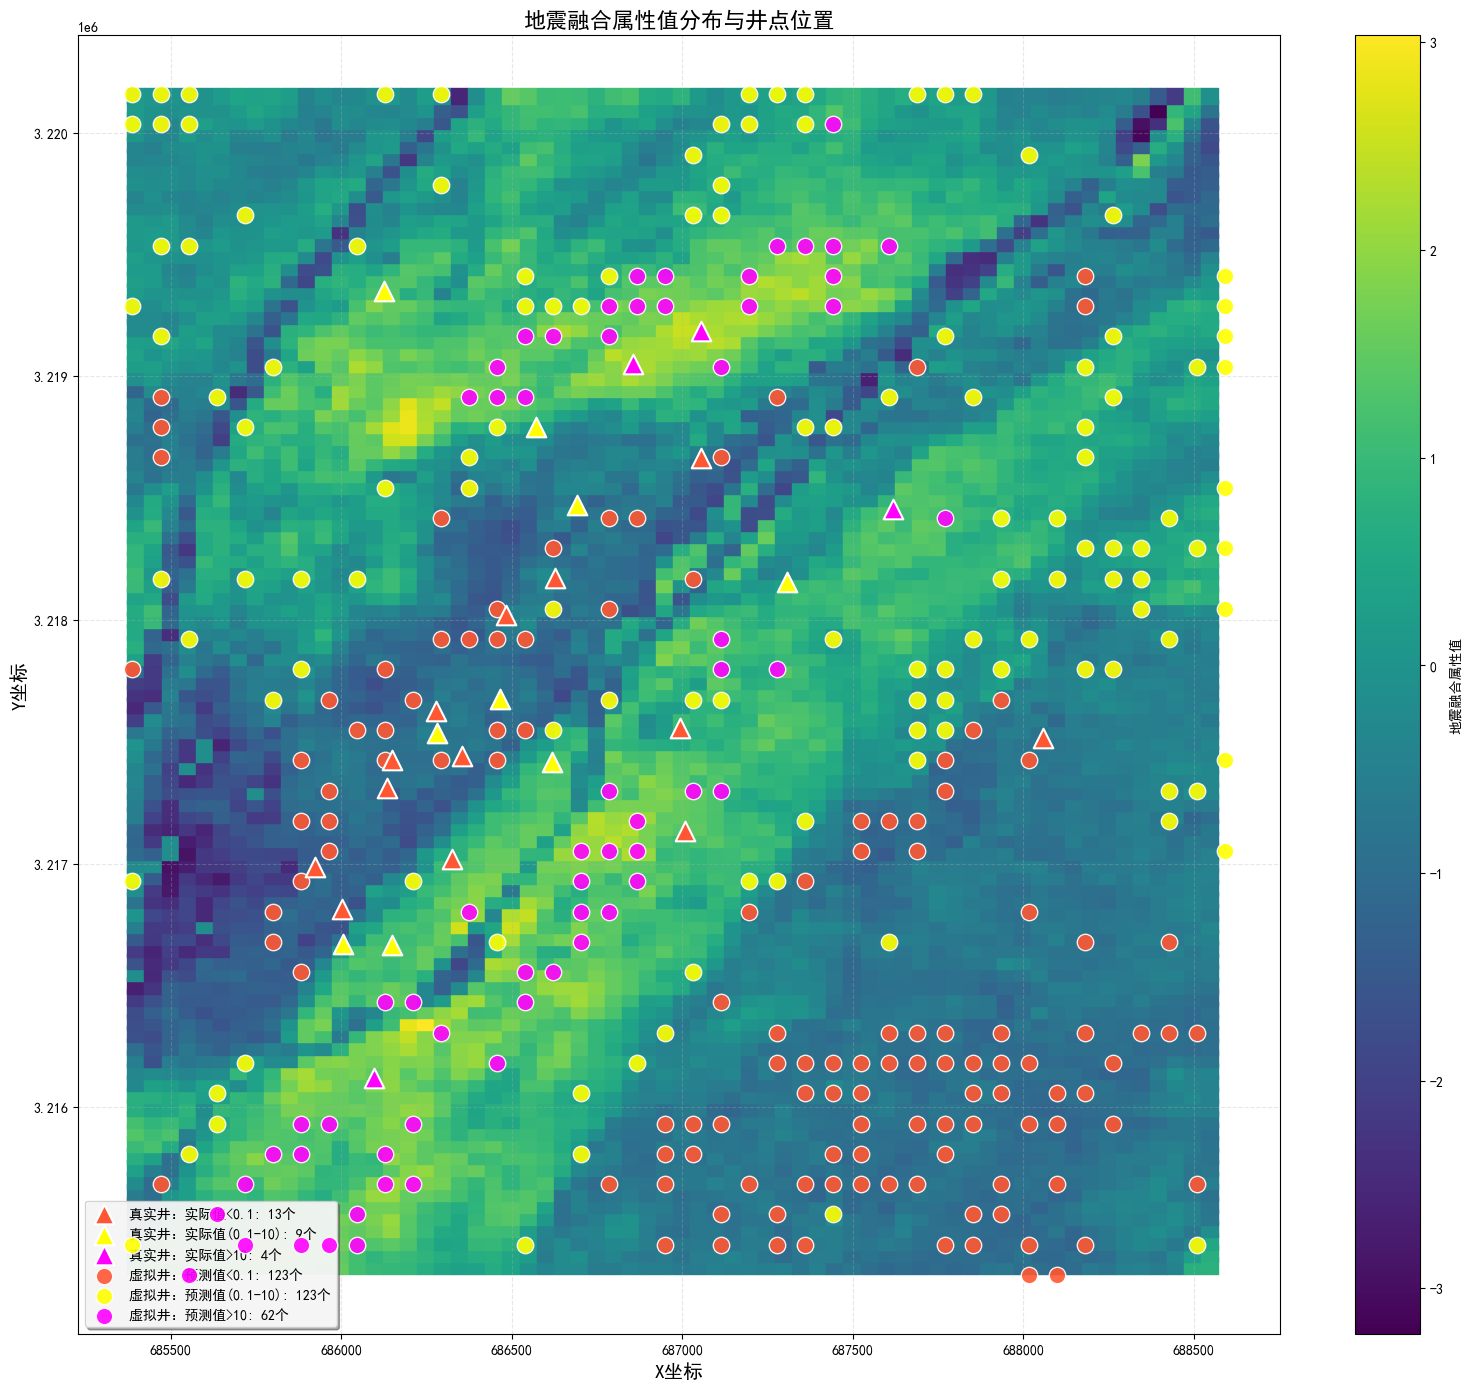

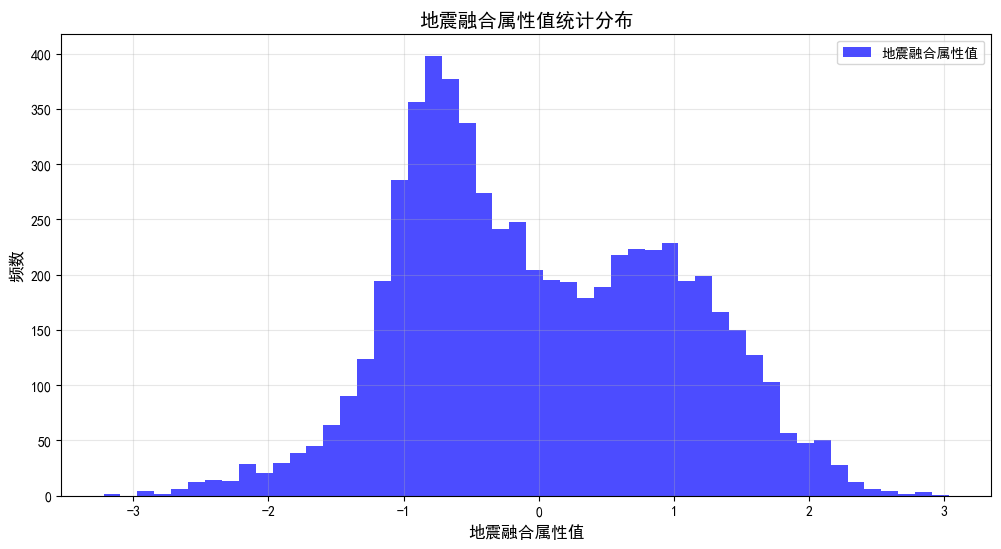

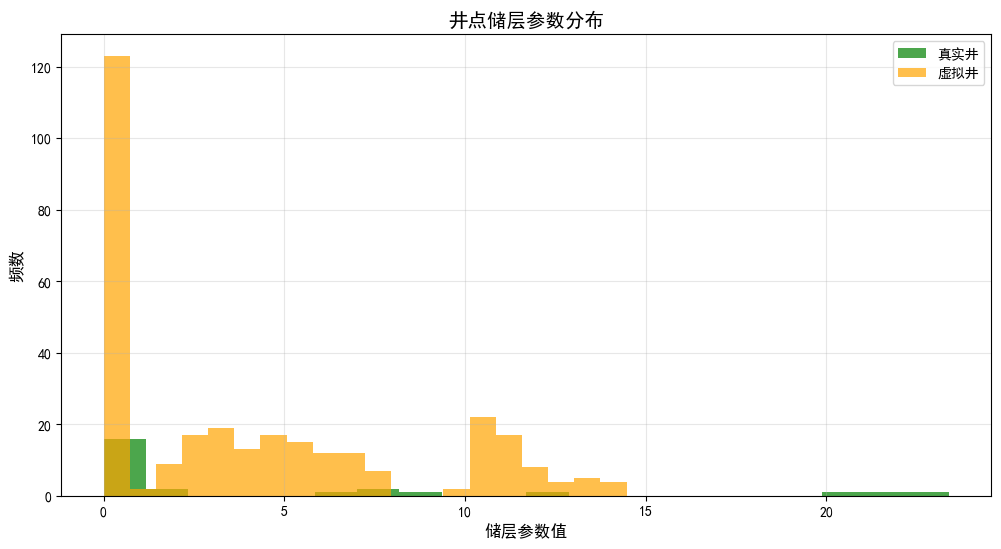

融合属性分布与井点位置可视化完成


In [15]:
# 准备小工区地震数据（使用已筛选的data_H6_2_attr_filtered）
# 1. 首先创建融合属性
print("为整个小工区地震数据创建融合属性...")

# 标准化数据
scaler = StandardScaler()
attr_data = seismic_attr_filtered[selected_features].copy()
attr_data_scaled = scaler.fit_transform(attr_data)

# 使用之前定义的create_fused_attribute函数创建融合属性
fused_attr = create_fused_attribute(attr_data_scaled, selected_features, correlation_weights)

# 将融合属性添加到地震数据中
seismic_attr_filtered["Fused_Attribute"] = fused_attr

# 2. 准备真实井点数据
real_wells = well_attr_filtered.copy()

# 3. 准备虚拟井点数据（使用之前优化选择的虚拟井）
pseudo_wells = seismic_samples[seismic_samples["Is_Selected"] == True].copy()

# 可视化融合属性分布与井点位置
visualize_attribute_map(
    data_points=seismic_attr_filtered,
    attribute_name="Fused_Attribute",
    attribute_label="地震融合属性值",
    real_wells=real_wells,
    pseudo_wells=pseudo_wells,
    target_column="Sand Thickness",
    output_dir=output_dir,
    filename_prefix="fused_attribute",
    class_thresholds=[0.1, 10],
    figsize=(16, 14),
    dpi=300,
    cmap="viridis",
    point_size=140,
    well_size=200,
)

print("融合属性分布与井点位置可视化完成")

## SVR、随机森林（限制树深）、XGBoost（控制学习率和复杂度）


======== 真实井点与虚拟井点结合建模 ========
加载了 308 个虚拟井点数据
真实井点数据数量: 26
使用的特征: ['Minimum amplitude', 'Half energy', 'Sum of amplitudes']
有效真实井点数据数量: 26 
合并后的样本数量: 334
训练集大小: 326, 测试集大小: 8

训练SVR模型...
SVR最佳参数: {'C': 10, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

SVR 模型评估:
  - RMSE: 3.4418
  - R²: 0.8053
  - MAE: 2.3276


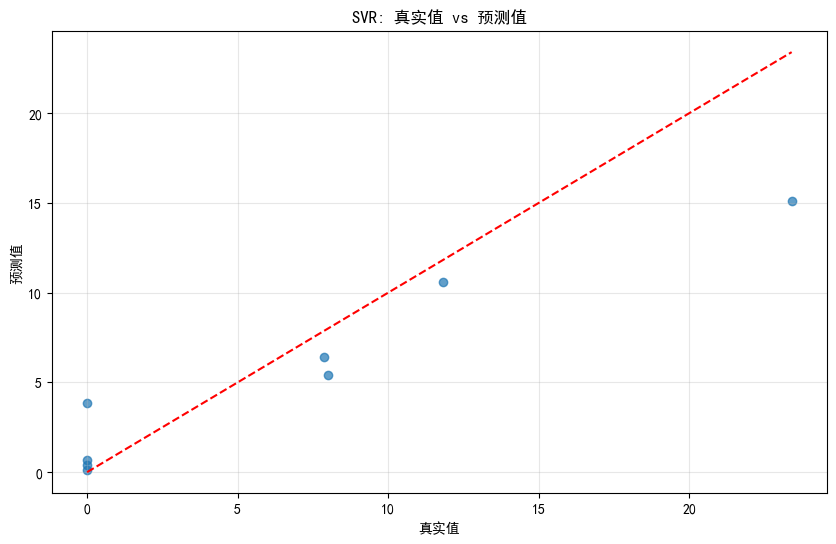


训练随机森林模型...
随机森林最佳参数: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 100}

随机森林 模型评估:
  - RMSE: 4.8654
  - R²: 0.6110
  - MAE: 3.4412


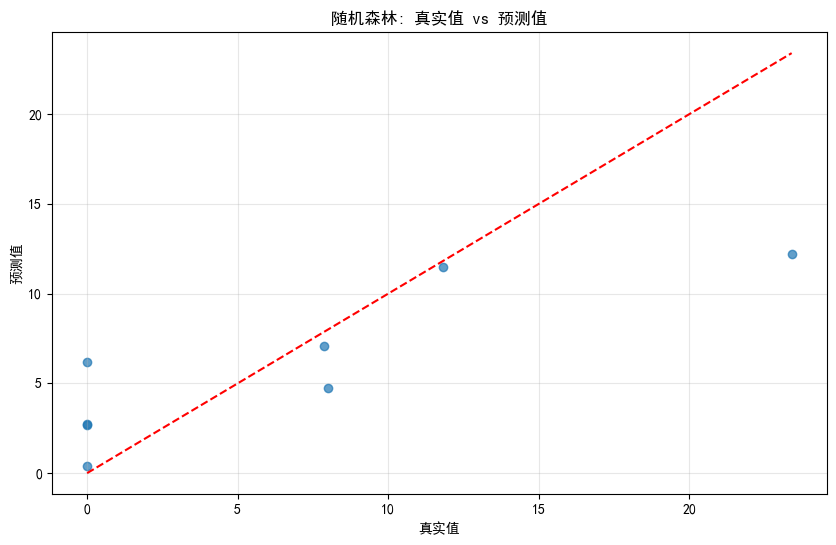


训练XGBoost模型...
XGBoost最佳参数: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}

XGBoost 模型评估:
  - RMSE: 3.6867
  - R²: 0.7767
  - MAE: 2.9179


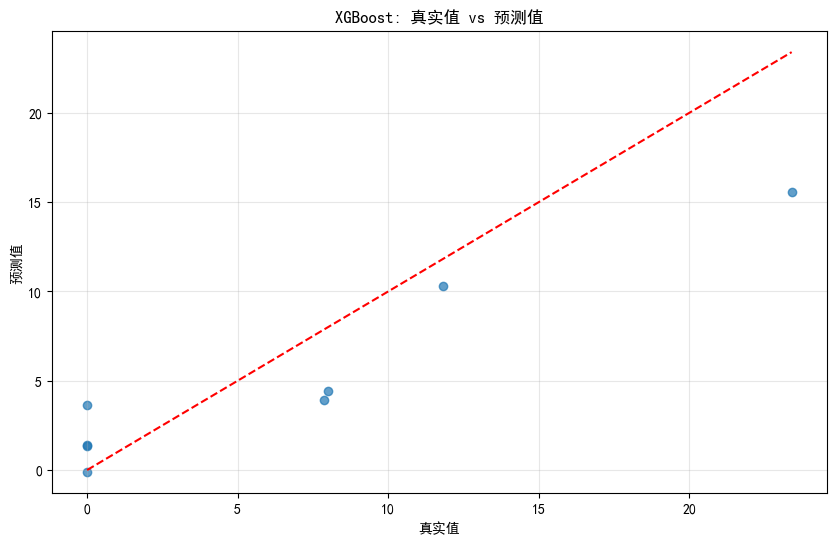


模型性能比较:
        模型      RMSE        R²       MAE
0      SVR  3.441806  0.805348  2.327579
1     随机森林  4.865443  0.611017  3.441171
2  XGBoost  3.686737  0.776658  2.917852

最佳模型: SVR

使用最佳模型为整个工区生成预测...


c:\Users\WangQinZhuo\miniconda3\envs\env-af\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


注意: 5942 个负的砂厚预测值已被替换为0

可视化预测结果...


c:\Users\WangQinZhuo\Program\attribute_fusion_0526\src\visualization.py:176: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


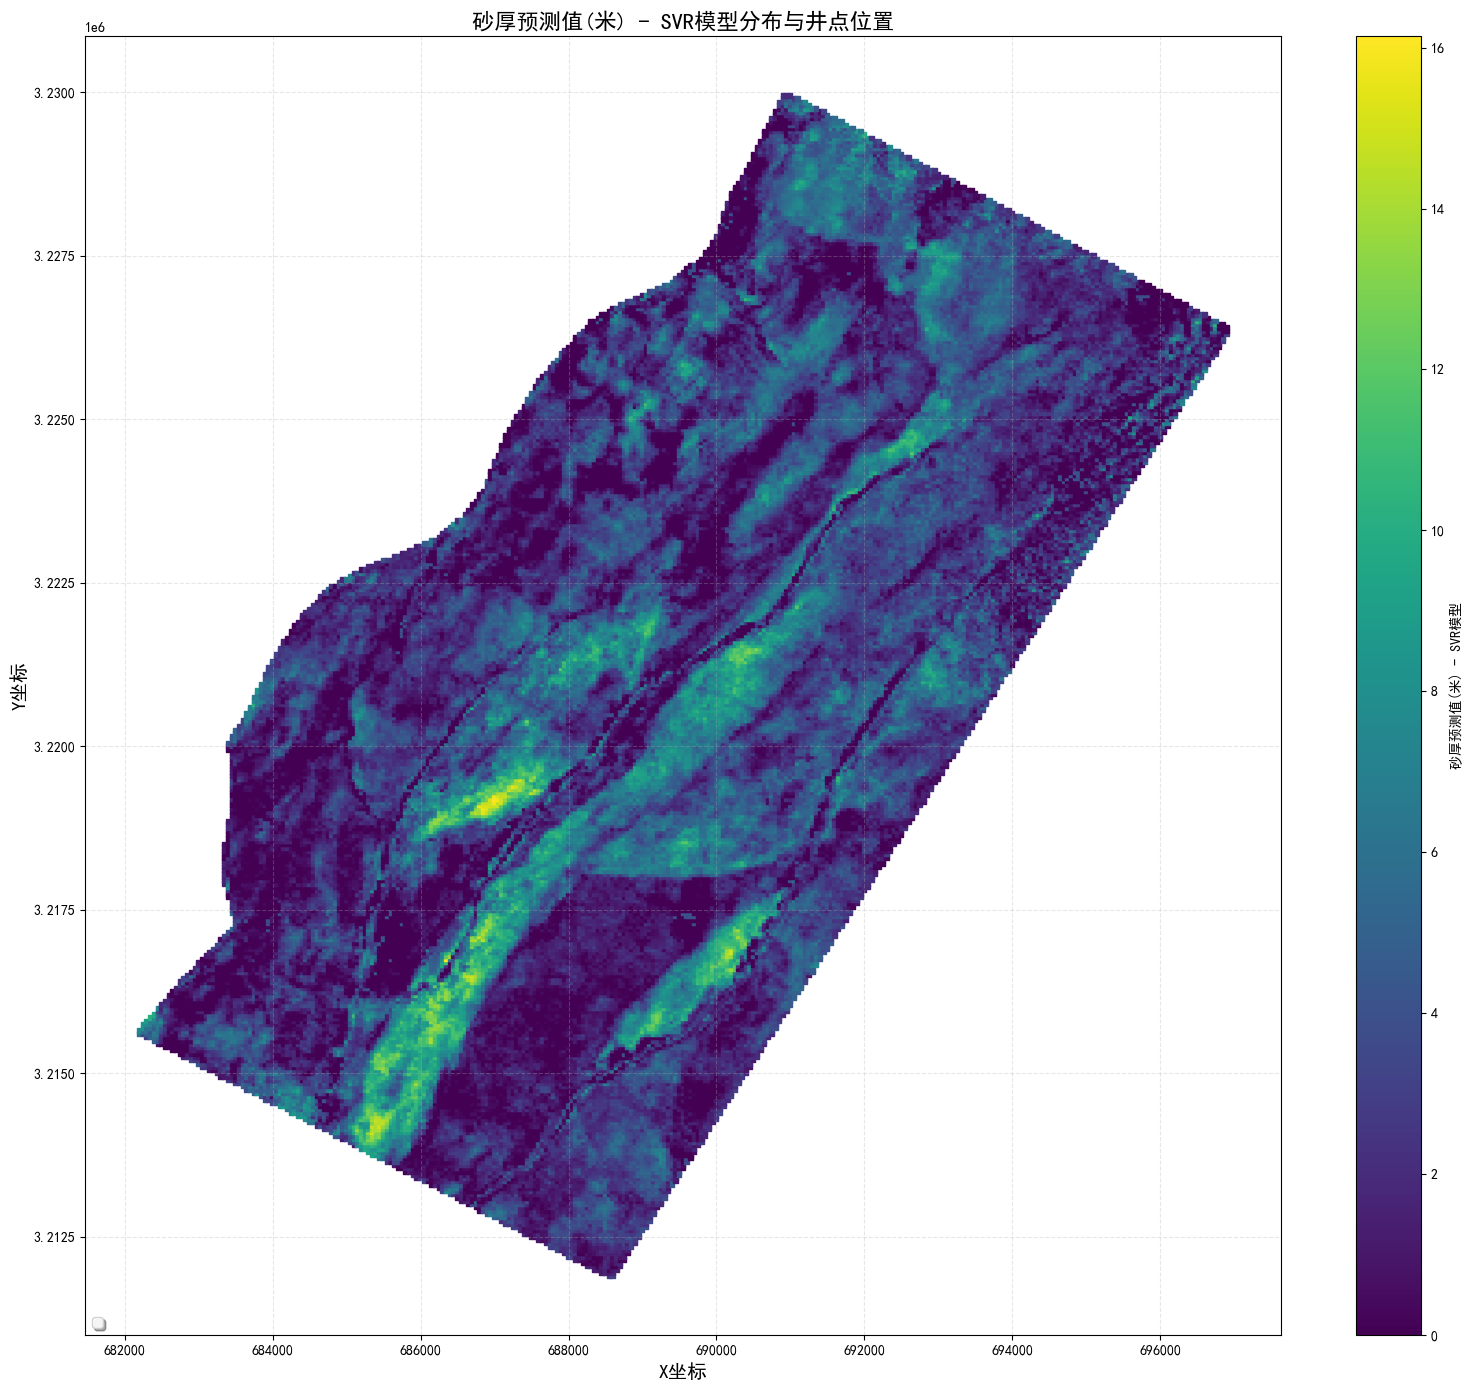

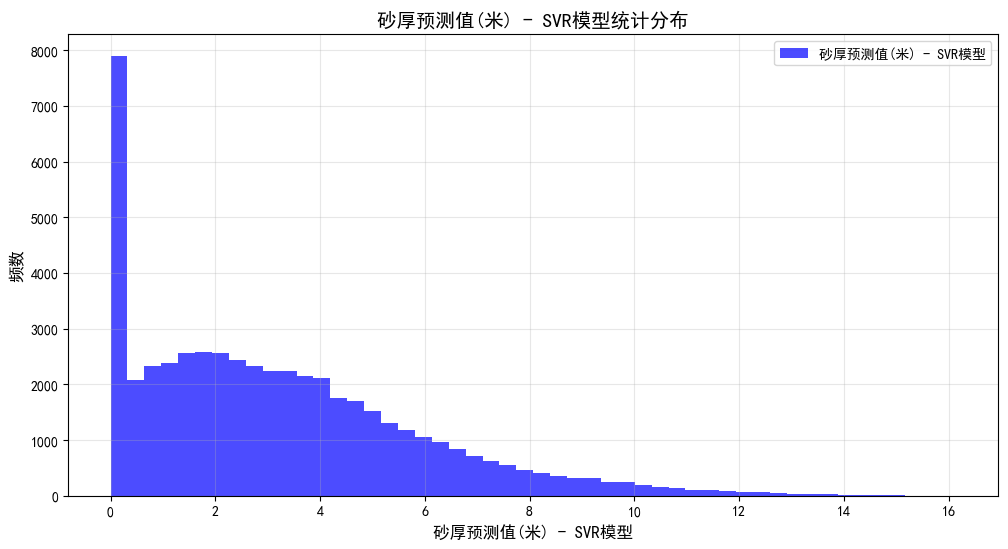


建模与预测完成。所有结果已保存到输出目录。


In [16]:
# 设置随机种子以确保结果可复现
np.random.seed(42)

print("======== 真实井点与虚拟井点结合建模 ========")

# 步骤1: 准备数据 - 合并真实样本和伪样本
pseudo_wells = pd.read_csv(os.path.join(output_dir, "optimized_pseudo_wells.csv"))
print(f"加载了 {len(pseudo_wells)} 个虚拟井点数据")

# 创建用于建模的真实井点数据
real_wells = well_attr_filtered.copy()
print(f"真实井点数据数量: {len(real_wells)}")

# 确定共同的特征列（选用之前筛选出的最佳特征）
common_features = selected_features.copy()
print(f"使用的特征: {common_features}")

# 确保真实井点和虚拟井点都有这些特征列
real_wells_valid = real_wells.dropna(subset=common_features + ["Sand Thickness"])
print(f"有效真实井点数据数量: {len(real_wells_valid)} ")

# 创建合并数据集
# 从真实井点中提取特征和目标
X_real = real_wells_valid[common_features].values
y_real = real_wells_valid["Sand Thickness"].values

# 从虚拟井点中提取特征和目标(使用平均预测作为虚拟井的砂厚)
X_pseudo = pseudo_wells[common_features].values
y_pseudo = pseudo_wells["Mean_Pred"].values  # 使用平均预测作为目标值

# 合并数据
X_combined = np.vstack((X_real, X_pseudo))
y_combined = np.concatenate((y_real, y_pseudo))
print(f"合并后的样本数量: {len(X_combined)}")

# 创建样本权重 - 给真实样本更高的权重
sample_weights = np.ones(len(X_combined))
# 设置真实样本权重为虚拟样本的2倍
sample_weights[: len(X_real)] = 2.0

# 步骤2: 划分训练集和测试集(仅使用真实样本做测试)
# 首先划分真实样本
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

# 合并真实训练样本和所有虚拟样本作为完整训练集
X_train = np.vstack((X_real_train, X_pseudo))
y_train = np.concatenate((y_real_train, y_pseudo))

# 创建训练样本权重
train_weights = np.ones(len(X_train))
# 设置真实样本权重为虚拟样本的2倍
train_weights[: len(X_real_train)] = 2.0

print(f"训练集大小: {len(X_train)}, 测试集大小: {len(X_real_test)}")

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_real_test)


# 步骤3: 模型训练与评估
# 创建评估函数
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, sample_weights=None):
    """评估模型性能并返回指标"""
    # 训练模型
    if sample_weights is not None:
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

    # 在测试集上预测
    y_pred = model.predict(X_test)

    # 计算指标
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n{model_name} 模型评估:")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R²: {r2:.4f}")
    print(f"  - MAE: {mae:.4f}")

    # 绘制真实值vs预测值散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--")
    plt.xlabel("真实值")
    plt.ylabel("预测值")
    plt.title(f"{model_name}: 真实值 vs 预测值")
    plt.grid(True, alpha=0.3)
    plt.savefig(
        os.path.join(output_dir, f"{model_name.lower().replace(' ', '_')}_pred_vs_true.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    return {"model": model, "rmse": rmse, "r2": r2, "mae": mae, "y_pred": y_pred}


# 模型1: 支持向量回归(SVR)
print("\n训练SVR模型...")
# SVR对特征数量敏感，使用较少特征以避免维度灾难
# 如果特征数量较多，可以考虑使用前2-3个最重要的特征
svr_features = min(3, len(common_features))
X_train_svr = X_train_scaled[:, :svr_features]
X_test_svr = X_test_scaled[:, :svr_features]

# 设置SVR参数网格
param_grid_svr = {"C": [0.1, 1, 10], "gamma": ["scale", 0.01, 0.1], "epsilon": [0.1, 0.2], "kernel": ["rbf"]}

# 创建并训练SVR模型
svr = SVR()
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_svr.fit(X_train_svr, y_train, sample_weight=train_weights)
best_svr = grid_search_svr.best_estimator_

print(f"SVR最佳参数: {grid_search_svr.best_params_}")
svr_results = evaluate_model(best_svr, X_train_svr, y_train, X_test_svr, y_real_test, "SVR", train_weights)

# 模型2: 随机森林(RandomForest) - 限制树深以避免过拟合
print("\n训练随机森林模型...")
param_grid_rf = {
    "n_estimators": [50, 100],
    "max_depth": [3, 4, 5],
    "min_samples_leaf": [3, 5],
    "max_features": ["sqrt", "log2"],
}

rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train, sample_weight=train_weights)
best_rf = grid_search_rf.best_estimator_

print(f"随机森林最佳参数: {grid_search_rf.best_params_}")
rf_results = evaluate_model(best_rf, X_train_scaled, y_train, X_test_scaled, y_real_test, "随机森林", train_weights)

# 模型3: XGBoost - 控制学习率和复杂度
print("\n训练XGBoost模型...")
param_grid_xgb = {
    "n_estimators": [50, 100],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_weight": [3, 5],
}

xgb = XGBRegressor(random_state=42)
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_xgb.fit(X_train_scaled, y_train, sample_weight=train_weights)
best_xgb = grid_search_xgb.best_estimator_

print(f"XGBoost最佳参数: {grid_search_xgb.best_params_}")
xgb_results = evaluate_model(best_xgb, X_train_scaled, y_train, X_test_scaled, y_real_test, "XGBoost", train_weights)

# 步骤4: 比较模型性能
models_comparison = pd.DataFrame(
    {
        "模型": ["SVR", "随机森林", "XGBoost"],
        "RMSE": [svr_results["rmse"], rf_results["rmse"], xgb_results["rmse"]],
        "R²": [svr_results["r2"], rf_results["r2"], xgb_results["r2"]],
        "MAE": [svr_results["mae"], rf_results["mae"], xgb_results["mae"]],
    }
)

print("\n模型性能比较:")
print(models_comparison)

# 保存比较结果
models_comparison.to_csv(os.path.join(output_dir, "model_comparison.csv"), index=False)

# 选择最佳模型(基于R²)
best_model_idx = models_comparison["R²"].idxmax()
best_model_name = models_comparison.loc[best_model_idx, "模型"]
print(f"\n最佳模型: {best_model_name}")

# 为地震数据创建预测
print("\n使用最佳模型为整个工区生成预测...")

# 准备地震数据
seismic_data = processed_seismic_full.copy()
X_seismic = seismic_data[common_features].fillna(seismic_data[common_features].mean())

# 标准化特征
X_seismic_scaled = scaler.transform(X_seismic)

# 根据最佳模型选择预测方法
if best_model_name == "SVR":
    X_seismic_model = X_seismic_scaled[:, :svr_features]
    predictions = best_svr.predict(X_seismic_model)
    best_model = best_svr
elif best_model_name == "随机森林":
    predictions = best_rf.predict(X_seismic_scaled)
    best_model = best_rf
else:  # XGBoost
    predictions = best_xgb.predict(X_seismic_scaled)
    best_model = best_xgb

# 将预测结果添加到地震数据
seismic_data["Predicted_Sand_Thickness"] = predictions

# 将负值预测设为0
if (predictions < 0).any():
    neg_count = (predictions < 0).sum()
    print(f"注意: {neg_count} 个负的砂厚预测值已被替换为0")
    seismic_data["Predicted_Sand_Thickness"] = seismic_data["Predicted_Sand_Thickness"].clip(lower=0)

# 保存预测结果
seismic_data.to_csv(os.path.join(output_dir, "seismic_with_predictions.csv"), index=False)

# 步骤5: 可视化预测结果
print("\n可视化预测结果...")

# 使用最佳模型进行可视化
visualize_attribute_map(
    data_points=seismic_data,
    attribute_name="Predicted_Sand_Thickness",
    attribute_label=f"砂厚预测值(米) - {best_model_name}模型",
    real_wells=real_wells_valid,
    pseudo_wells=None,
    target_column="Thickness of facies(1: Fine sand)",
    output_dir=output_dir,
    filename_prefix=f"predicted_sand_thickness_{best_model_name.lower()}",
    class_thresholds=[0.1, 10],  # 分类阈值：低值(<0.1)、中值(0.1-10)、高值(>10)
    figsize=(16, 14),
    dpi=300,
    cmap="viridis",
    point_size=10,
    well_size=50,
)

# 可选：特征重要性分析（对于树模型）
if best_model_name in ["随机森林", "XGBoost"]:
    print("\n分析特征重要性...")

    # 获取特征重要性
    if best_model_name == "随机森林":
        importances = best_rf.feature_importances_
    else:
        importances = best_xgb.feature_importances_

    # 创建特征重要性DataFrame
    feature_importance_df = pd.DataFrame({"特征": common_features, "重要性": importances})
    feature_importance_df = feature_importance_df.sort_values("重要性", ascending=False)

    # 绘制特征重要性
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df["特征"], feature_importance_df["重要性"])
    plt.xlabel("特征重要性")
    plt.title(f"{best_model_name}模型特征重要性")
    plt.tight_layout()
    plt.savefig(
        os.path.join(output_dir, f"{best_model_name.lower()}_feature_importance.png"), dpi=300, bbox_inches="tight"
    )
    plt.show()

    # 保存特征重要性
    feature_importance_df.to_csv(
        os.path.join(output_dir, f"{best_model_name.lower()}_feature_importance.csv"), index=False
    )

print("\n建模与预测完成。所有结果已保存到输出目录。")